# Import Model

In [ ]:
import torch
import torch.nn as nn
class MultiTaskDecoder(nn.Module):
    def __init__(self, input_dim, output_dim=35):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        # 每個 cell type 都有一個 Linear 頭部（1 個 scalar output）
        self.heads = nn.ModuleList([nn.Linear(64, 1) for _ in range(output_dim)])

    def forward(self, x):
        shared_feat = self.shared(x)  # (B, 64)
        outs = [head(shared_feat) for head in self.heads]  # List[(B, 1)] × 35
        return torch.cat(outs, dim=1)  # (B, 35)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y  # Channel-wise attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, H, W)
        avg_out = x.mean(dim=1, keepdim=True)  # → (B, 1, H, W)
        attn = self.conv(avg_out)              # → (B, 1, H, W)
        attn = self.sigmoid(attn)              # → (B, 1, H, W)
        return x * attn                        # → (B, C, H, W)

class SimpleCNNEncoder(nn.Module):
    def __init__(self, out_dim, in_channels=4):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SEBlock(32),             # Channel-wise Attention ✅
            SpatialAttention(),      # Spatial Attention ✅
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),             # Channel-wise Attention ✅
            SpatialAttention(),      # Spatial Attention ✅
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, out_dim)

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x




class VisionWithCoord_MTL(nn.Module):
    def __init__(self, cnn_out_dim=64, output_dim=35):
        super().__init__()
        self.encoder = SimpleCNNEncoder(out_dim=cnn_out_dim, in_channels=4)
        self.decoder = MultiTaskDecoder(cnn_out_dim + 2, output_dim)

    def forward(self, tile, coords):
        feat = self.encoder(tile)                # (B, 64)
        x = torch.cat([feat, coords], dim=1)     # (B, 66)
        out = self.decoder(x)                    # (B, 35)
        return out


model = VisionWithCoord()

In [ ]:

from python_scripts.import_model import load_model_classes
from python_scripts.operate_model import get_model_inputs

# ==============================================
# 範例使用
# ==============================================
folder = "./output_folder/CNN+MLP/"  # 替換成實際的資料夾路徑，該路徑下應有 model.py
try:
    loaded_classes = load_model_classes(folder)
    print("載入的 class 名稱:", list(loaded_classes.keys()))
except Exception as e:
    print("載入模型 class 發生錯誤:", e)    


載入的 class 名稱: ['CNNEncoder', 'MLPDecoder', 'VisionMLPModelWithCoord']


In [7]:
# 假設 loaded_classes 是你已經從 model.py 載入的 class 字典
name_of_class = 'VisionMLPModelWithCoord'
ModelClass = loaded_classes.get(name_of_class)
if ModelClass is None:
    raise ValueError(f"找不到 {name_of_class} 這個 class")
# 這裡呼叫 ModelClass() 建立實例，注意不能直接用 name_of_class() (因為它是一個字串)
model = ModelClass()  # 如果需要參數，請在此處傳入
get_model_inputs(model)
#print("建立的模型實例:", model)


Model forward signature: (center_tile, subtiles, neighbor_tiles, coords)


<Signature (center_tile, subtiles, neighbor_tiles, coords)>

# Import training data

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from python_scripts.import_data import importDataset, preprocess_data
from torch.utils.data import DataLoader
from torchvision import transforms

# 載入資料
tile = torch.load("./dataset/final_data/M_tiles.pt")
#subtiles = torch.load("./train_dataset_sep_v2/subtiles.pt")
#neighbor_tiles = torch.load("./train_dataset_sep_v2/neighbor_tiles.pt")
label = torch.load("./dataset/final_data/log2_labels.pt")
meta = torch.load("./dataset/final_data/meta_info.pt")

raw_coords = []
for _meta in meta['coords']:
    if _meta is not None:
         x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

train_dataset = {
        'tile': tile,
        #'subtiles': subtiles,
        #'neighbor_tiles': neighbor_tiles,
        'coords': normalized_coords,
        'label': label
    }

my_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

image_keys = ['tile']

#processed_data = preprocess_data(train_dataset, image_keys, my_transform)

train_dataset = importDataset(
        data_dict=train_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might b

Model forward signature: (tile, coords)


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_84283/1697294966.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label = torch.load("./dataset/final_data/log

In [3]:
train_dataset = importDataset(
        data_dict=processed_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
        )

NameError: name 'processed_data' is not defined

In [3]:
train_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([4, 112, 112]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.821, std: 0.146
📏 coords shape: torch.Size([2]) | dtype: torch.float32 | min: -0.284, max: 1.071, mean: 0.393, std: 0.959
--- coords head (前 10 個元素):
tensor([-0.2844,  1.0713])
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: -0.841, max: 2.134, mean: 0.171, std: 1.117
--- label head (前 10 個元素):
tensor([-0.6579, -0.4472, -0.6355, -0.6286, -0.8406,  1.8673, -0.3878, -0.4904,
         1.9321,  1.8796])
✅ All checks passed!


In [4]:
from torch.utils.data import random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 26179 samples
✅ Val: 6545 samples


#  Train model

In [5]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import get_model_inputs, train_one_epoch, evaluate, predict, EarlyStopping, plot_losses, plot_per_cell_metrics
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = "output_folder/with_all_preprocess_log2/SE+SA/"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


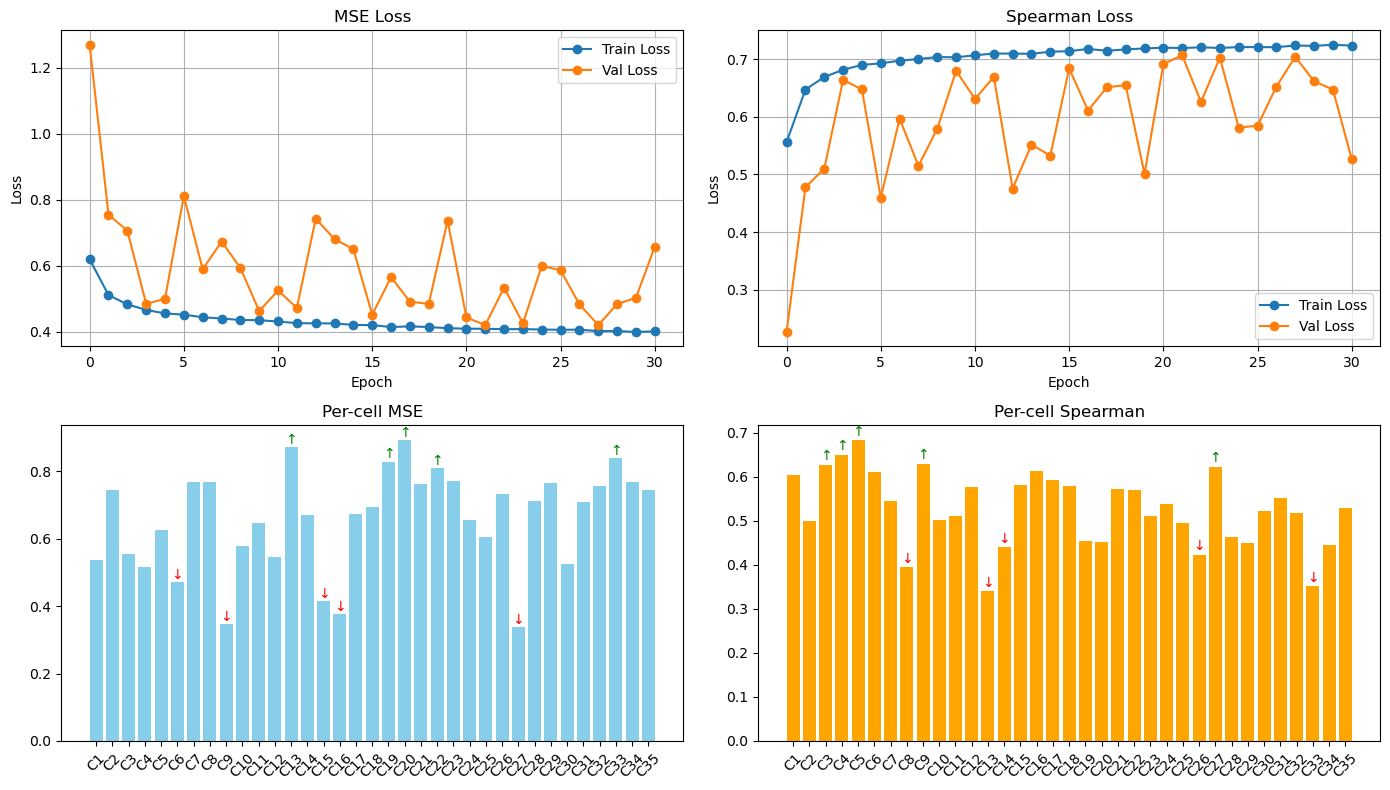

EarlyStopping counter: 3/10


Training:  84%|████████▍ | 687/819 [00:23<00:04, 30.91it/s, avg=0.401, loss=0.409]

In [ ]:
# ---------------------------
# 🔧 設定裝置
# ---------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------
# 初始化模型 & 優化器
# ---------------------------
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
# loss_fn = spearman_loss

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# ---------------------------
# 儲存 log 的設定
# ---------------------------
log_path = os.path.join(save_folder, "training_log.csv")
log_file = open(log_path, mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# ---------------------------
# 用來畫圖的變數
# ---------------------------
train_losses = []
val_losses = []
train_spearmanes = []
val_spearmanes = []

# ---------------------------
# 指定最佳模型儲存路徑
# ---------------------------
best_model_path = os.path.join(save_folder, "best_model.pt")
loss_plot_path = os.path.join(save_folder, "loss_curve.png")

# ---------------------------
# 開始訓練
# ---------------------------
num_epochs = 500
best_val_loss = float('inf')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
display(fig)  # 初始顯示圖形

for epoch in range(num_epochs):
    train_loss, train_spearman = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman, mse_per_cell, spearman_per_cell = evaluate(model, val_loader, loss_fn, device)
    
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    # 儲存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("✅ Saved best model!")

    # 調整學習率
    scheduler.step(val_loss)

    # 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch + 1, train_loss, val_loss, val_spearman, lr])

    # 印出 Epoch 結果
    print(f"Epoch {epoch + 1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # 更新 log 列表並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_spearmanes.append(train_spearman)
    val_spearmanes.append(val_spearman)
    


    # plot loss
    plot_losses(train_losses, val_losses, ax=axes[0][0], title="MSE Loss")
    plot_losses(train_spearmanes, val_spearmanes, ax=axes[0][1], title="Spearman Loss")

    cell_names = [f"C{i+1}" for i in range(35)]
    # plot per-cell stats
    plot_per_cell_metrics(mse_per_cell, spearman_per_cell,cell_names,
                        ax_mse=axes[1][0], ax_spearman=axes[1][1])
    

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)  # 清除之前的輸出
    display(fig)
    plt.pause(0.1)  # 暫停以便更新畫面

    # Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# 關閉 CSV log 檔案
log_file.close()

# 儲存最終圖形
fig.savefig(loss_plot_path)
plt.close(fig)
print(f"訓練結束，loss 曲線圖已儲存至 {loss_plot_path}")


# Predict

In [9]:
# ===== 需要的 Libraries =====
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import csv


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

model.load_state_dict(torch.load(best_model_path))
model.eval()


✅ Using device: mps


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_80095/2031120942.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

VisionWithCoord(
  (encoder): SimpleCNNEncoder(
    (cnn): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2, out_features=32, bias=True)
          (3): Sigmoid()
        )
      )
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNo

In [10]:
import torch
from torch.utils.data import Dataset
import inspect
from python_scripts.import_data import importDataset, preprocess_data
from python_scripts.operate_model import get_model_inputs
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 正確方式

test_data = torch.load("./dataset/final_data/test_dataset.pt")

raw_coords = []
for _meta in test_data['coords']:
    if _meta is not None:
        x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)

coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

test_dataset = {
        'tile': torch.stack([torch.tensor(img).permute(2, 0, 1) for img in test_data['M_tiles']]),
        #'subtiles': test_data['subtiles'],
        #'neighbor_tiles': test_data['neighbor_tiles'],
        'coords': normalized_coords,
        'label': np.zeros((len(test_data['M_tiles']), 35))
    }
my_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

#image_keys = ['tile']



#processed_data = preprocess_data(test_dataset, image_keys, my_transform)

test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_80095/3359058249.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("./dataset/final_data

Model forward signature: (tile, coords)


In [11]:
test_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([4, 112, 112]) | dtype: torch.float32 | min: 0.000, max: 1.000, mean: 0.779, std: 0.203
📏 coords shape: torch.Size([2]) | dtype: torch.float32 | min: -0.393, max: 0.416, mean: 0.012, std: 0.572
--- coords head (前 10 個元素):
tensor([-0.3929,  0.4160])
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 0.000, max: 0.000, mean: 0.000, std: 0.000
--- label head (前 10 個元素):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
✅ All checks passed!


In [12]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
test_preds = predict(model, test_loader, device)
test_preds

array([[-0.7244791 ,  0.7476932 , -0.6921396 , ...,  0.81845963,
        -0.17581698, -0.13071012],
       [-0.3175371 ,  0.30473715, -0.34256613, ...,  0.61660945,
         0.01905951, -0.02981448],
       [-0.89469576,  0.5314908 , -0.73575294, ...,  1.1219403 ,
         0.08342865,  0.5069166 ],
       ...,
       [-0.07698631, -0.57291174, -0.10464764, ..., -0.35401294,
        -0.5151369 , -0.68847364],
       [ 0.27143732, -0.41466573,  0.2276552 , ..., -0.42145967,
        -0.02054647, -0.01385128],
       [-1.0107443 ,  1.1618494 , -0.81740344, ...,  1.4749404 ,
         0.04282692,  0.56538993]], dtype=float32)

In [ ]:
from python_scripts.revert_utils import (
    load_json_params,
    revert_log2_predictions,
    revert_boxcox_predictions
)

# 還原 Box-Cox
params = load_json_params("./dataset/boxcox_zscore_params.json")
restored = revert_boxcox_predictions(test_preds, params)


🔁 測試 revert_log2_predictions
[[ 1.01396717e+00 -8.07002121e-03  1.80511435e+00  1.13151159e-01
   2.00707840e+00  7.59623606e-02  6.96093327e-02  7.63244836e-03
  -4.43450703e-02  4.99186394e-04  1.08874982e-02 -2.43959104e-02
   4.05517143e-03  2.29893147e-02  6.26831059e-02  8.12215671e-02
   2.64344670e-01  2.31829931e-02  1.36808254e-02 -1.33865438e-03
  -2.55863969e-02  1.04127442e-02  1.75559047e-03 -3.42817691e-02
   8.95906936e-02  2.71020152e-03  7.19174871e-02  1.14335168e-02
  -2.35451263e-02  5.75979741e-03  1.10113500e-01  8.37440865e-02
   1.95191196e-02  1.52221790e-02 -7.13266282e-02]
 [ 3.28478151e+00  3.26228103e-01 -1.51059413e-01  2.10342036e-01
  -3.70963169e-01  9.46231454e-02  1.08288662e-02  4.10010213e-03
   3.99134882e-01  1.60557299e-02 -6.11376033e-03  1.01965609e-03
   7.99558069e-03  1.75983651e-02  1.73605903e-01  1.38104129e+00
   1.07006572e-02 -5.08118852e-02  1.18068944e-03  6.97391458e-02
  -2.20179089e-03  2.30087185e-02 -5.02672957e-03  1.61468807e

In [15]:
from python_scripts.revert_utils import (
    load_json_params,
    revert_log2_predictions,
)
params = load_json_params(json_path="./dataset/zscore_params.json")

# 或還原 log2
params = load_json_params("./dataset/zscore_params.json")
restored = revert_log2_predictions(test_preds, params, add_constant=1)

restored

array([[-7.0450306e-03,  1.8575585e-01,  1.5825987e-02, ...,
         2.3544550e-02,  1.0931969e-02,  4.4451356e-02],
       [ 2.2088373e-01,  1.3803029e-01,  1.5340519e-01, ...,
         2.0336270e-02,  1.4862299e-02,  5.0315619e-02],
       [-8.9267373e-02,  1.6221654e-01, -1.4466047e-04, ...,
         2.8387189e-02,  1.6163826e-02,  8.2069755e-02],
       ...,
       [ 3.7950754e-01,  4.9068213e-02,  2.5755036e-01, ...,
         5.0487518e-03,  4.1248798e-03,  1.2618661e-02],
       [ 6.4650667e-01,  6.4578295e-02,  4.1893542e-01, ...,
         3.9949417e-03,  1.4062285e-02,  5.1246524e-02],
       [-1.4138556e-01,  2.3218727e-01, -2.9372156e-02, ...,
         3.4048796e-02,  1.5342593e-02,  8.5586667e-02]], dtype=float32)

In [16]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

submission_path = os.path.join(save_folder, "submission.csv")

ensemble_df = pd.DataFrame(restored, columns=[f"C{i+1}" for i in range(restored.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv(submission_path, index=False)
print(f"✅ Saved submission.csv in {submission_path}")


✅ Saved submission.csv in output_folder/with_all_preprocess_log2/SE/submission.csv
